### This notebook details the processing, formatting and analysis of the data generated from the simulation runs with different group sizes.  

Thejasvi Beleyur, Max Planck Institute for Ornithology, Seewiesen
Last Updated : September 2019

In [1]:
import random
import dill 
import datetime as dt
import glob 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial as spatial
import sys 
sys.path.append('..//CPN//')
import numpy as np 
import statsmodels.api as sm
from tqdm import tqdm_notebook, tqdm
import brokenaxes

In [2]:
%matplotlib notebook

In [3]:
## A series of functions to parse the  simulation output
def get_run_uuid(sim_output, **kwargs):
    sim_id, sim_data = sim_output
    return(sim_id['uuid'])

def get_run_random_seed(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    random_seed = sim_ids['np.random.seed']
    return(random_seed)

def get_num_echoes_heard(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    num_echoes_heard = np.sum(sim_data[0])
    return(num_echoes_heard)

which_echo = {True: 1 , False:0}

def get_echoids(sim_data, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    echo_indices = np.argwhere(sim_data[0]==which_echo[heard]).flatten()
    return(echo_indices)    

def get_echo_levels(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output
    echo_ids = get_echoids(sim_data, **kwargs)
    
    echo_levels = sim_data[1]['target_echoes'].loc[echo_ids,'level']
    return(echo_levels)
    

def get_group_size(sim_output, **kwargs):
    ''' This function is necessary because of the
    stupid way I stored the parameter sets using classes
    '''
    sim_ids, sim_data = sim_output
    num_bats_in_group = sim_data[0].size +1 
    return(num_bats_in_group)

def split_by_groupsize(df):
    all_subdfs = []
    group_sizes = np.unique(df['groupsize'])
    for each_groupsize in group_sizes:
        subdf = df[df['groupsize']==each_groupsize]
        all_subdfs.append(subdf)
    return(group_sizes, all_subdfs)



def get_individual_positions(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    _, _b, geometry = sim_data
    positions = geometry['positions']
    return(positions)


def get_detection_distance(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output 
    echo_inds = get_echoids(sim_data, **kwargs)
    individuals_inds = echo_inds +1 # because focal individ is 0 index
    all_positions = get_individual_positions(sim_output)
    heard_individual_positions = all_positions[individuals_inds,:]
    focal_ind = all_positions[0,:]
    distances = spatial.distance
    
    positions_of_relevance = np.row_stack((focal_ind, heard_individual_positions))
    distances = spatial.distance_matrix(positions_of_relevance, 
                                        positions_of_relevance)[1:,0]
    return(distances)

def get_detection_azimuth(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output 
    echo_inds = get_echoids(sim_data, **kwargs)
    
    echoes_heard, sounds, geom = sim_data
    echoes = sounds['target_echoes']
    echo_azimuth = np.array(echoes['theta'][echo_inds])
    
    return(echo_azimuth)


def get_echo_levels(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output 
    echo_inds = get_echoids(sim_data, **kwargs)
    
    echoes_heard, sounds, geom = sim_data
    echoes = sounds['target_echoes']
    echo_level = np.array(echoes['level'][echo_inds])
    
    return(echo_level)
    


def get_nearest_neighbour_distances(sim_output, **kwargs):
    '''Extract the distance to the nearest neighbour of the focal bat
    
    Parameters
    -----------
    sim_output : output from a simulation run. 
    
    Keyword Arguments
    ------------------
    nearest_nbrs : int.
                    The number of distance measurements given. 
                    Defaults to 5. 


    Returns
    ---------
    nearest_neighbour_distances : 1 x nearest_nbrs np.array
    '''
    nearest_nbrs = kwargs.get('nearest_nbrs',5)
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)[1:,0]
    nearest_neighbour_distances = np.sort(distances)[:nearest_nbrs]
    return(nearest_neighbour_distances)

def get_furthest_bat2bat_distance(sim_output, **kwargs):
    '''
    '''
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)
    furthest_distance = np.max(distances)
    return(furthest_distance)
    

def extract_parameter_values(one_sim_result, **kwargs):
    '''
    Extracts the variables from the simulation result
    by extracting the values from the 
    'parameter set'
    
    Parameters
    -----------
    one_sim_results : tuple/list with 2 entries. 
                      entry 1 should have the simulation identifiers
                      entry 2 may be anything.
    Keyword Arguments
    -----------------
    variables_to_extract : list with str.
                           The names of the variables that are to be extracted.
                           Notes: 
                           If 'source_level' is one of the variables - only the 
                           emitted levels as dBSPL is output - the reference distance
                           is *ignored*.

    Returns
    --------
    param_set : list.
                A list with the numeric or Boolean values of each of the variables extracted. 
    '''
    sim_identifiers, sim_data = one_sim_result
    all_parameter_values = sim_identifiers['parameter_set']
    
    param_set_for_this_run = []
    for each in kwargs['variables_to_extract']:
        if each != 'source_level':
            param_set_for_this_run.append(all_parameter_values[each])
        elif each == 'source_level':
            param_set_for_this_run.append(all_parameter_values[each]['dBSPL'])
    
    return(param_set_for_this_run)
        
make_to_string = lambda X: str(X)

def join_all_parameters(parameter_list):
    '''
    '''
    params_as_string = map(make_to_string, parameter_list)
    param_joined = '*'.join(params_as_string)
    return(param_joined)

def make_paramset_id(sim_output, **kwargs):
    '''
    '''
    all_parameter_values = extract_parameter_values(sim_output, **kwargs)
    param_id = join_all_parameters(all_parameter_values)
    return(param_id)


def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)

def load_and_extract(simresult_path, extraction_functions, **kwargs):
    '''
    Parameters
    ----------
    simresult_path : str/path object

    extraction_functions : list/tuple with one or more function that work on 
                            the simulation output

    Keyword Arguments
    -----------------
    As defined by the extraction functions. 
    Every key must be unique and correspond to a particular extraction function!

    Returns
    ---------
    extracted_output : object type thats returned by the extraction function
    '''
    simresult = load_simresult(simresult_path)
    extracted_outputs = [ extract(simresult, **kwargs) for extract in extraction_functions]
    return(extracted_outputs)

In [4]:
# Some functions that deal with formatting the simulation data after it's been loaded from the csv file. 

def format_nearest_neighbour_distances(nearest_nbr_entry):
    '''
    Parameters
    ----------
    nearest_nbr_entry : string. 
                        pd.DataFrame column entry with 
                        the following format 
                        '[<float>, <float>, <float>]'
    
    Returns
    -------
    np.array
    
    '''
    only_float_as_string = nearest_nbr_entry[1:-1]
    all_strings_separated = only_float_as_string.split()
    floats = map(lambda X : float(X), all_strings_separated)
    
    distances = np.array(floats)
    return(distances)
    
    


In [6]:
results_folder = '..//simulations/effect_of_group_size//'

In [7]:
all_results = glob.glob(results_folder+'*.simresults')
some_results =random.sample(all_results, int(len(all_results)*1.0))

In [8]:
extraction_fns = [get_num_echoes_heard, get_group_size, get_furthest_bat2bat_distance,
                 get_nearest_neighbour_distances, get_detection_distance, get_run_uuid,
                  get_run_random_seed,make_paramset_id, extract_parameter_values,
                 get_echo_levels, get_detection_azimuth]
keyword_arguments = {'nearest_nbrs':3}

In [9]:
keyword_arguments['variables_to_extract'] = ['heading_variation', 'echocall_duration','atmospheric_attenuation','min_spacing','source_level',
                        'interpulse_interval', 'implement_shadowing',
                                            ]

In [10]:
#### Un comment into Python cells if you need to re-run the analysis by loading the raw data 
#### this can take a few minutes 
%time extracted_simdata = Parallel(n_jobs=7)(delayed(load_and_extract)(each, extraction_fns, **keyword_arguments) for each in tqdm(some_results))

100%|██████████| 5192/5192 [03:44<00:00, 23.10it/s]


CPU times: user 1min 52s, sys: 16.9 s, total: 2min 9s
Wall time: 3min 45s


In [11]:
echoes_heard = []
group_size = []
group_diameter = []
nearest_3nbrs = []
nbr_detection_range = []
uuid = []
seed = []
param_ids = []
parameter_values = []
echo_levels = []
detection_angle = []
for each in extracted_simdata:
    for variable, list_to_append in zip(each, [echoes_heard, group_size, group_diameter,
                                              nearest_3nbrs, nbr_detection_range,
                                              uuid, seed, param_ids, parameter_values,
                                              echo_levels, detection_angle]):
        list_to_append.append(variable)
        

In [12]:
simulation_data = pd.DataFrame(data = {'nbrs_detected':echoes_heard,
                                      'group_size':group_size,
                                      'group_diameter':group_diameter,
                                      'nearest_neighbour_distance':nearest_3nbrs,
                                      'nbrs_detected_distance':nbr_detection_range,
                                      'uuid':uuid,
                                      'seed':seed,
                                      'paramset_id':param_ids,
                                      'parameters_joint':parameter_values,
                                      'echo_levels':echo_levels,
                                      'detection_azimuth':detection_angle})

In [13]:
simulation_data.head()

,detection_azimuth,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid
0,"[-90.4335, 13.2211]","[59.97788040361667, 59.98997754936779]",4.961325,50,2,"[0.8259183550216943, 0.9408239853485514]","[0.5347990116907497, 0.5632176453876093, 0.603...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,764755704,6a12c593-121d-4098-9c5e-24a171ba3162
1,[],[],14.464217,400,0,[],"[0.5348806731288878, 0.6827016414046211, 0.732...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,773090721,821059ed-01a3-41dc-8248-812eff83e941
2,[],[],14.400488,400,0,[],"[0.5247513804243383, 0.6281652336504252, 0.736...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,743536204,dc327564-7a9a-426c-8aca-ebfe91264747
3,"[-85.1613, 3.7218]","[69.37578996862315, 62.973971136258385]",7.236058,100,2,"[0.5042787469661305, 0.8024125215815618]","[0.5042787469661305, 0.5686831955850962, 0.691...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,567569631,317f3234-6378-4293-aa0e-b91979e4d176
4,[],[],7.063962,100,0,[],"[0.6100705461664272, 0.6491795252571972, 0.712...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,558626364,7ff80f53-8b76-4bc9-8b73-d2079b7f4d07


In [14]:
column_names = keyword_arguments['variables_to_extract']

for each in column_names:
    simulation_data[each] = np.nan
        

In [15]:
def split_parameters_joint_to_separate_columns(row, col_names):
    for colnam, value in zip(col_names, row['parameters_joint']):
        row[colnam] = value
    return(row)

In [16]:
%time simulation_data = simulation_data.apply(split_parameters_joint_to_separate_columns, 1, col_names=column_names)    

CPU times: user 1.15 s, sys: 3.51 ms, total: 1.15 s
Wall time: 1.16 s


In [17]:
simulation_data.head()

,detection_azimuth,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"[-90.4335, 13.2211]","[59.97788040361667, 59.98997754936779]",4.961325,50,2,"[0.8259183550216943, 0.9408239853485514]","[0.5347990116907497, 0.5632176453876093, 0.603...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,764755704,6a12c593-121d-4098-9c5e-24a171ba3162,10,0.0025,-1,0.5,100,0.1,True
1,[],[],14.464217,400,0,[],"[0.5348806731288878, 0.6827016414046211, 0.732...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,773090721,821059ed-01a3-41dc-8248-812eff83e941,10,0.0025,-1,0.5,100,0.1,True
2,[],[],14.400488,400,0,[],"[0.5247513804243383, 0.6281652336504252, 0.736...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,743536204,dc327564-7a9a-426c-8aca-ebfe91264747,10,0.0025,-1,0.5,100,0.1,True
3,"[-85.1613, 3.7218]","[69.37578996862315, 62.973971136258385]",7.236058,100,2,"[0.5042787469661305, 0.8024125215815618]","[0.5042787469661305, 0.5686831955850962, 0.691...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,567569631,317f3234-6378-4293-aa0e-b91979e4d176,10,0.0025,-1,0.5,100,0.1,True
4,[],[],7.063962,100,0,[],"[0.6100705461664272, 0.6491795252571972, 0.712...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,558626364,7ff80f53-8b76-4bc9-8b73-d2079b7f4d07,10,0.0025,-1,0.5,100,0.1,True


In [18]:
yyyymmdd = dt.datetime.now()
timestamp = str([yyyymmdd.year,yyyymmdd.month,yyyymmdd.day,yyyymmdd.hour])

In [19]:
#simulation_data.to_csv('simulation_data_'+timestamp+'.csv')

In [20]:
#simulation_data.to_json('simulation_data_'+timestamp+'.csv')

In [21]:
#simulation_data = pd.read_csv('simulation_data_'+timestamp+'.csv')

In [22]:
##### thanks to https://realpython.com/fast-flexible-pandas/#but-i-heard-that-pandas-is-slow
data_store = pd.HDFStore('groupsize_data'+timestamp+'.h5')
data_store['simulation_data'] = simulation_data
data_store.close()

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['detection_azimuth', 'echo_levels', 'nbrs_detected_distance', 'nearest_neighbour_distance', 'parameters_joint', 'paramset_id', 'uuid']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
data_stores_in_folder = glob.glob('groupsize*.h5')

In [24]:
data_stores_in_folder

['groupsize_data[2019, 9, 23, 8].h5',
 'groupsize_data[2019, 9, 26, 15].h5',
 'groupsize_data[2019, 9, 23, 11].h5',
 'groupsize_data[2019, 9, 27, 12].h5']

In [25]:
#load the saved data 
data_load = pd.HDFStore(data_stores_in_folder[-1])
simulation_data = data_load['simulation_data']
data_load.close()

In [26]:
simulation_data.head()

,detection_azimuth,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"[-90.4335, 13.2211]","[59.97788040361667, 59.98997754936779]",4.961325,50,2,"[0.8259183550216943, 0.9408239853485514]","[0.5347990116907497, 0.5632176453876093, 0.603...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,764755704,6a12c593-121d-4098-9c5e-24a171ba3162,10,0.0025,-1,0.5,100,0.1,True
1,[],[],14.464217,400,0,[],"[0.5348806731288878, 0.6827016414046211, 0.732...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,773090721,821059ed-01a3-41dc-8248-812eff83e941,10,0.0025,-1,0.5,100,0.1,True
2,[],[],14.400488,400,0,[],"[0.5247513804243383, 0.6281652336504252, 0.736...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,743536204,dc327564-7a9a-426c-8aca-ebfe91264747,10,0.0025,-1,0.5,100,0.1,True
3,"[-85.1613, 3.7218]","[69.37578996862315, 62.973971136258385]",7.236058,100,2,"[0.5042787469661305, 0.8024125215815618]","[0.5042787469661305, 0.5686831955850962, 0.691...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,567569631,317f3234-6378-4293-aa0e-b91979e4d176,10,0.0025,-1,0.5,100,0.1,True
4,[],[],7.063962,100,0,[],"[0.6100705461664272, 0.6491795252571972, 0.712...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,558626364,7ff80f53-8b76-4bc9-8b73-d2079b7f4d07,10,0.0025,-1,0.5,100,0.1,True


### Were there any repeated seeds ? 

Every simulation run was executed in parallel with other runs. If I had relied on a common seed to set the simulations I would have gotten multiple *repeated* simulation outputs! I ended up using a unique 32 integer to seed every simulation run. The 32 bit integer was derived from a [uuid](https://en.wikipedia.org/wiki/Universally_unique_identifier) value generated at the initiation of the parallel simulation run. Even though uuid's are supposed to be *very* unique everytime they are generated - the fact that I brought them down to a 32 bit integer to actually set my simulations meant that there may have been some seeds that were repeated. 

 Repeated seeds are not a problem per se as long as they were repeated across different parameter sets. If the same seed was used to set two simulations with the same parameter set - the results would be identical and one of them must be removed from this dataset. 

In [27]:
seeds, count = np.unique(simulation_data['seed'], return_counts=True)
# if every seed was present only once, all seeds would be counted only once
print(np.unique(count))

[1]


#### There were no repeated seeds - let's move on to the next part

### What is the spatial span of the created groups ?
#### The bats were placed t o have a minimum distance between each other. What was the largest distance between any two bats - in essence, what was the *diameter*  of the group ?

<IPython.core.display.Javascript object>


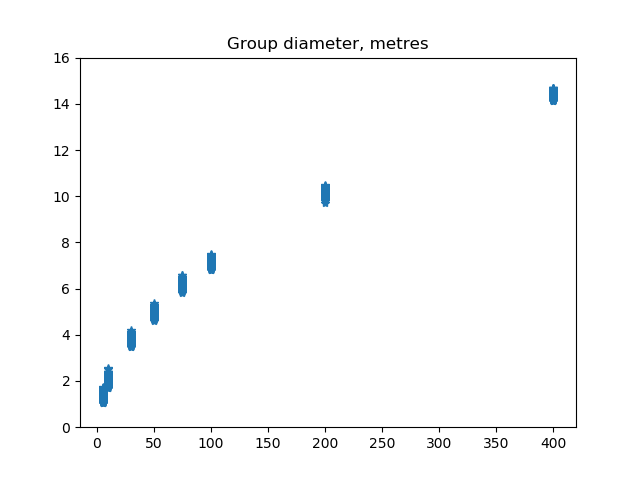

Text(0.5,1,'Group diameter, metres')

In [28]:
plt.figure()
plt.plot(simulation_data['group_size'],
             simulation_data['group_diameter'], 
          '*')
plt.yticks(np.arange(0,18,2), np.arange(0,18,2));plt.title('Group diameter, metres')
#plt.ylabel('Largest distance between two bats, metres');plt.xlabel('Minimum inter-bat spacing, metres')
#plt.grid();plt.yticks(np.arange(7,16),np.arange(7,16));

## What is the *effective* inter-neighbour distance ? 

### In the simulations bats were randomly placed in 2D Poisson disc placement of individuals [(Bridson)](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf). The Poisson disc sampling method is a fast way to place many points that are randomly distributed while still maintaining a minimum inter-neighbour distance. This method is superior to a purely random placement of points as this results in very sparse or very dense areas. 

### Since the Poisson disc sampling method is random and only defines a *minimum* neighbour distance, I want to characterise the effective neighbour distance that was obtained. 

In [29]:
by_minspacing = simulation_data.groupby('min_spacing')

In [30]:
nearest_nbr_dist = {}
for spacing, df in by_minspacing:
    nearest_nbr_distances = df['nearest_neighbour_distance'].reset_index(drop=True)
    nearest_nbr_dist[spacing] = np.concatenate(nearest_nbr_distances)

In [31]:
nearest_nbr_dists_for_plot = [nearest_nbr_dist[0.5]]

<IPython.core.display.Javascript object>


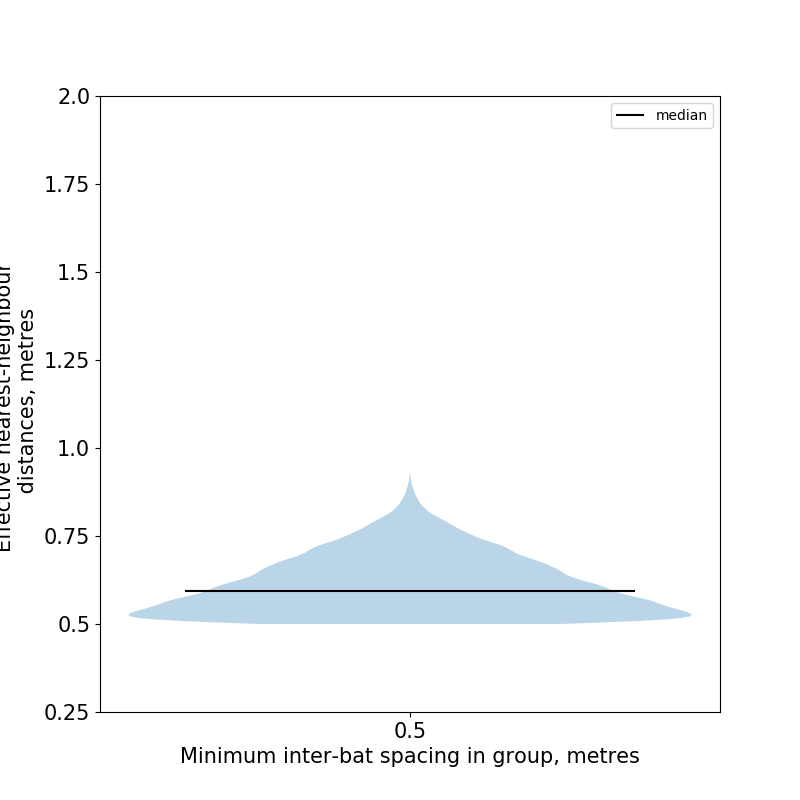

In [32]:
plt.figure(figsize=(8,8))
plt.violinplot(nearest_nbr_dists_for_plot, 
                           showextrema=False)
plt.xticks([1,2],[0.5,1.0],fontsize=15)
medians = map(np.median,nearest_nbr_dists_for_plot)
plt.hlines(medians, [0.8,1.8],[1.2,2.2], label='median')
plt.legend(fontsize=10)
plt.xlabel('Minimum inter-bat spacing in group, metres', fontsize=15)
plt.ylabel('Effective nearest-neighbour \n distances, metres', fontsize=15)
plt.yticks(np.arange(0.25,2.25,0.25), np.arange(0.25,2.25,0.25),fontsize=15);


### The effective nearest-neighbour distances, as measured from the three nearest neighbours of the focal bat is:


In [33]:
# for 0.5 m minimum spacing:
neighbour_spacing_pctile_50cm = np.percentile(nearest_nbr_dist[0.5], [5,50,95])
neighbour_spacing_pctile_50cm/0.5

array([1.01552045, 1.1871679 , 1.53319363])

In [34]:
# the realised inter-neighbour distances by the ideal (and unachievable) 0.5 m distance
neighbour_spacing_pctile_50cm

array([0.50776022, 0.59358395, 0.76659681])

#### How many simulation runs represent each group size?


In [35]:
simulation_data.groupby(['group_size']).size()

group_size
5       500
10      500
30      500
50     1000
75      500
100    1000
200     500
400     692
dtype: int64

Every group size simulation is represented by at least 500  runs. 

### How does the number of neighbours detected per call vary across group size?


In [36]:
data_by_groupsize = simulation_data.groupby(['group_size'])

In [37]:
nbrs_detected_data = {}
nbrs_detected_data['num_nbrs'] = []
nbrs_detected_data['median_num_nbrs'] = []
nbrs_detected_data['90%ile_num_nbrs'] = []
groupsizes= []
for groupsize, dataframe in data_by_groupsize:
    groupsizes.append(groupsize)
    nbrs_detected_data['num_nbrs'].append(np.array(dataframe['nbrs_detected']))
    nbrs_detected_data['median_num_nbrs'].append(np.median(np.array(dataframe['nbrs_detected'])))
    nbrs_detected_data['90%ile_num_nbrs'].append(np.percentile(np.array(dataframe['nbrs_detected']), 90))

In [53]:
breakup_x_axis  = np.arange(1,len(groupsizes)+1)+0.5


<IPython.core.display.Javascript object>


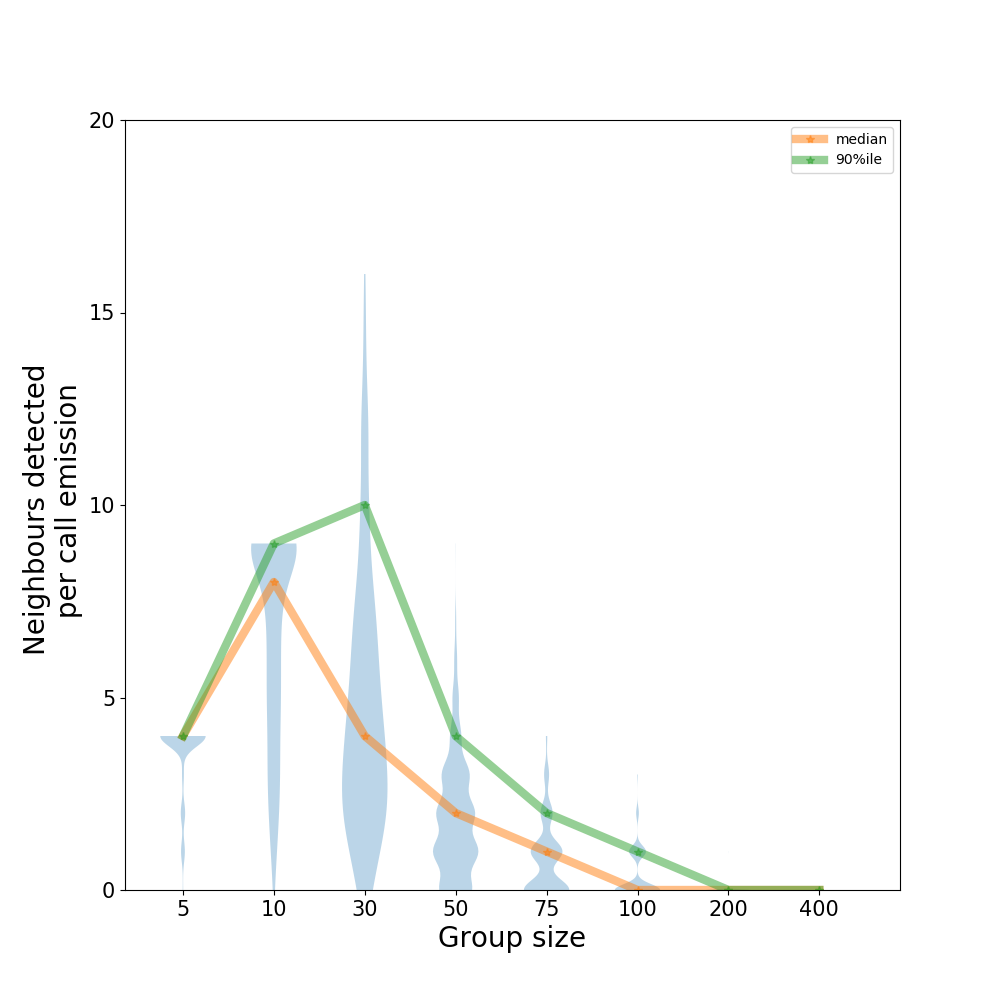

(0, 20)

In [61]:
plt.figure(figsize=(10,10))
plt.violinplot(nbrs_detected_data['num_nbrs'], showextrema=False)
plt.plot(np.arange(1,len(groupsizes)+1),nbrs_detected_data['median_num_nbrs'],
         '-*',linewidth=6, alpha=0.5,label='median')
plt.plot(np.arange(1,len(groupsizes)+1), nbrs_detected_data['90%ile_num_nbrs'],
        '-*',linewidth=6, alpha=0.5, label='90%ile')
plt.vlines(breakup_x_axis, -1,20, 'w',linewidth=30,alpha=1.0)
plt.yticks(np.arange(0,21,5),fontsize=15)
plt.xticks(range(1,len(groupsizes)+1),groupsizes,
           fontsize=15)
plt.legend(); plt.ylabel('Neighbours detected \n per call emission', fontsize=20)
plt.xlabel('Group size', fontsize=20)
plt.ylim(0,20)

The number of neighbours detected shows an increase with group size initially and then drops sharply down beyond 30 bats. 


### How does the probability of detecting at least one neighbour change with group size?

In [42]:
def calculate_geqNneighbour(num_detected_neighbours, N):
    '''Calculates the proportion of an array-like
    object that is >= N.
    
    '''
    geq_N = np.float64(np.sum(num_detected_neighbours>=N))
    proportion_geq_N = geq_N/len(num_detected_neighbours)
    return(proportion_geq_N)
    

In [62]:
nbrs_detected_data['0neighbours'] = [ 1-calculate_geqNneighbour(each,1)  for each in nbrs_detected_data['num_nbrs']]
nbrs_detected_data['geq_1neighbour'] = [ calculate_geqNneighbour(each,1)  for each in nbrs_detected_data['num_nbrs']]
nbrs_detected_data['geq_2neighbour'] = [ calculate_geqNneighbour(each,2)  for each in nbrs_detected_data['num_nbrs']]
nbrs_detected_data['geq_3neighbour'] = [ calculate_geqNneighbour(each,3)  for each in nbrs_detected_data['num_nbrs']]
nbrs_detected_data['geq_4neighbour'] = [ calculate_geqNneighbour(each,4)  for each in nbrs_detected_data['num_nbrs']]

In [44]:
nbrs_detected_data['geq_1neighbour']

[0.992, 0.992, 0.952, 0.801, 0.524, 0.307, 0.004, 0.0]

<IPython.core.display.Javascript object>


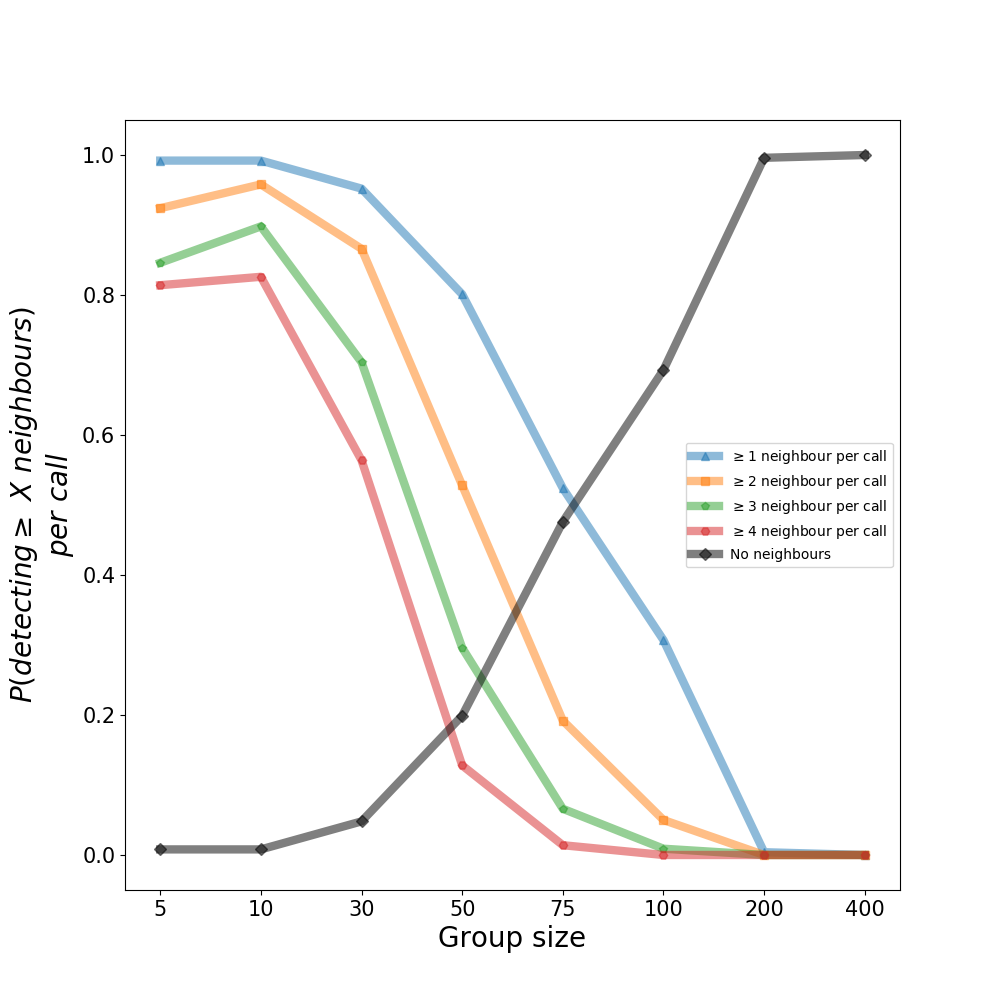

Text(0.5,0,'Group size')

In [73]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(1,len(groupsizes)+1), 
         nbrs_detected_data['geq_1neighbour'], '-^', linewidth=6, alpha=0.5, label='$\geq1$ neighbour per call')
plt.plot(np.arange(1,len(groupsizes)+1), 
         nbrs_detected_data['geq_2neighbour'], '-s', linewidth=6, alpha=0.5, label='$\geq2$ neighbour per call')
plt.plot(np.arange(1,len(groupsizes)+1), 
         nbrs_detected_data['geq_3neighbour'], '-p', linewidth=6, alpha=0.5, label='$\geq3$ neighbour per call')
plt.plot(np.arange(1,len(groupsizes)+1), 
         nbrs_detected_data['geq_4neighbour'], '-H', linewidth=6, alpha=0.5, label='$\geq4$ neighbour per call')
plt.plot(np.arange(1,len(groupsizes)+1), 
         nbrs_detected_data['0neighbours'], '-Dk', linewidth=6, alpha=0.5, label='No neighbours')

plt.yticks(fontsize=15)
plt.xticks(np.arange(1,len(groupsizes)+1),
           groupsizes,fontsize=15)
plt.legend()
plt.ylabel('$P(detecting \geq \ X \ neighbours)$'+'\n'+ '$per \ call$',
          fontsize=20)
plt.xlabel('Group size',
          fontsize=20)

In [46]:
simulation_data.head()

,detection_azimuth,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"[-90.4335, 13.2211]","[59.97788040361667, 59.98997754936779]",4.961325,50,2,"[0.8259183550216943, 0.9408239853485514]","[0.5347990116907497, 0.5632176453876093, 0.603...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,764755704,6a12c593-121d-4098-9c5e-24a171ba3162,10,0.0025,-1,0.5,100,0.1,True
1,[],[],14.464217,400,0,[],"[0.5348806731288878, 0.6827016414046211, 0.732...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,773090721,821059ed-01a3-41dc-8248-812eff83e941,10,0.0025,-1,0.5,100,0.1,True
2,[],[],14.400488,400,0,[],"[0.5247513804243383, 0.6281652336504252, 0.736...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,743536204,dc327564-7a9a-426c-8aca-ebfe91264747,10,0.0025,-1,0.5,100,0.1,True
3,"[-85.1613, 3.7218]","[69.37578996862315, 62.973971136258385]",7.236058,100,2,"[0.5042787469661305, 0.8024125215815618]","[0.5042787469661305, 0.5686831955850962, 0.691...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,567569631,317f3234-6378-4293-aa0e-b91979e4d176,10,0.0025,-1,0.5,100,0.1,True
4,[],[],7.063962,100,0,[],"[0.6100705461664272, 0.6491795252571972, 0.712...","[10, 0.0025, -1, 0.5, 100, 0.1, True]",10*0.0025*-1*0.5*100*0.1*True,558626364,7ff80f53-8b76-4bc9-8b73-d2079b7f4d07,10,0.0025,-1,0.5,100,0.1,True


In [47]:
nbrs_detected_data['detected_distances'] = [ np.concatenate(np.array(dataframe['nbrs_detected_distance'])) for groupsize, dataframe in data_by_groupsize]
nbrs_detected_data['median_detected_distances'] = map(np.median, nbrs_detected_data['detected_distances'])
nbrs_detected_data['90%ile_detected_distances'] = map(lambda X : np.percentile(X,90),
                                                      nbrs_detected_data['detected_distances'][:-1])

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


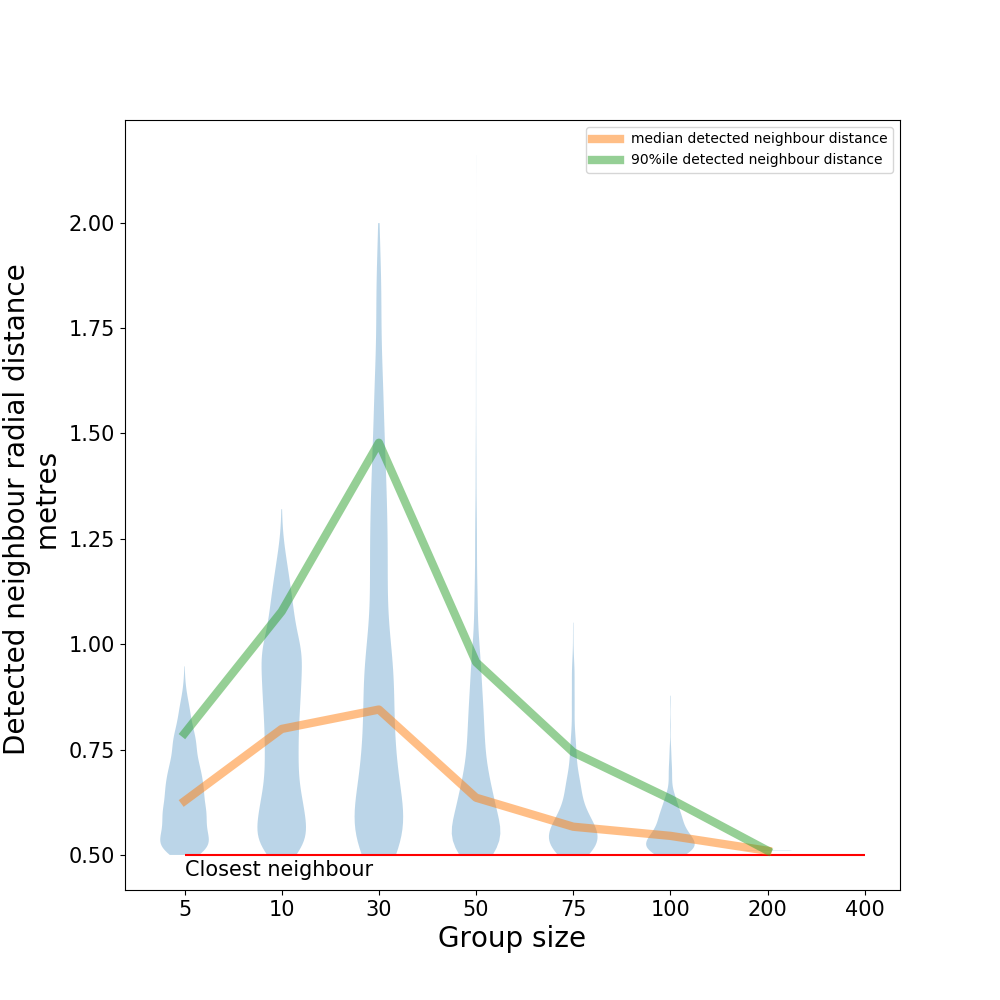

In [48]:
plt.figure(figsize=(10,10))
plt.violinplot(nbrs_detected_data['detected_distances'][:-1], 
                                                   showextrema=False,
                                                )
plt.plot(np.arange(1,9), nbrs_detected_data['median_detected_distances'], linewidth=6,
        alpha=0.5, label='median detected neighbour distance')
plt.plot(np.arange(1,8), nbrs_detected_data['90%ile_detected_distances'], linewidth=6,
        alpha=0.5, label='90%ile detected neighbour distance')
plt.xticks(np.arange(1,9), groupsizes)
plt.hlines(0.5,1,8, 'r'); 
plt.text(1.0,0.45,'Closest neighbour', fontsize=15)
plt.ylabel('Detected neighbour radial distance \n metres', fontsize=20);plt.yticks(fontsize=15)
plt.xlabel('Group size', fontsize=20);plt.xticks(fontsize=15)
plt.legend()


### Which neighbours are detected in the azimuthal plane ? 

In [49]:
nbrs_detected_data['neighbours_azimuth'] = [ np.concatenate(np.array(dataframe['detection_azimuth'])) for groupsize, dataframe in data_by_groupsize]
nbrs_detected_data['median_neighbours_azimuth'] = [ np.median(each)  for each in nbrs_detected_data['neighbours_azimuth'] ]
nbrs_detected_data['95%ile_neighbours_azimuth'] = [ np.percentile(each, 92.5)  for each in nbrs_detected_data['neighbours_azimuth'][:-1] ]
nbrs_detected_data['5%ile_neighbours_azimuth'] = [ np.percentile(each, 2.5)  for each in nbrs_detected_data['neighbours_azimuth'][:-1] ]

<IPython.core.display.Javascript object>


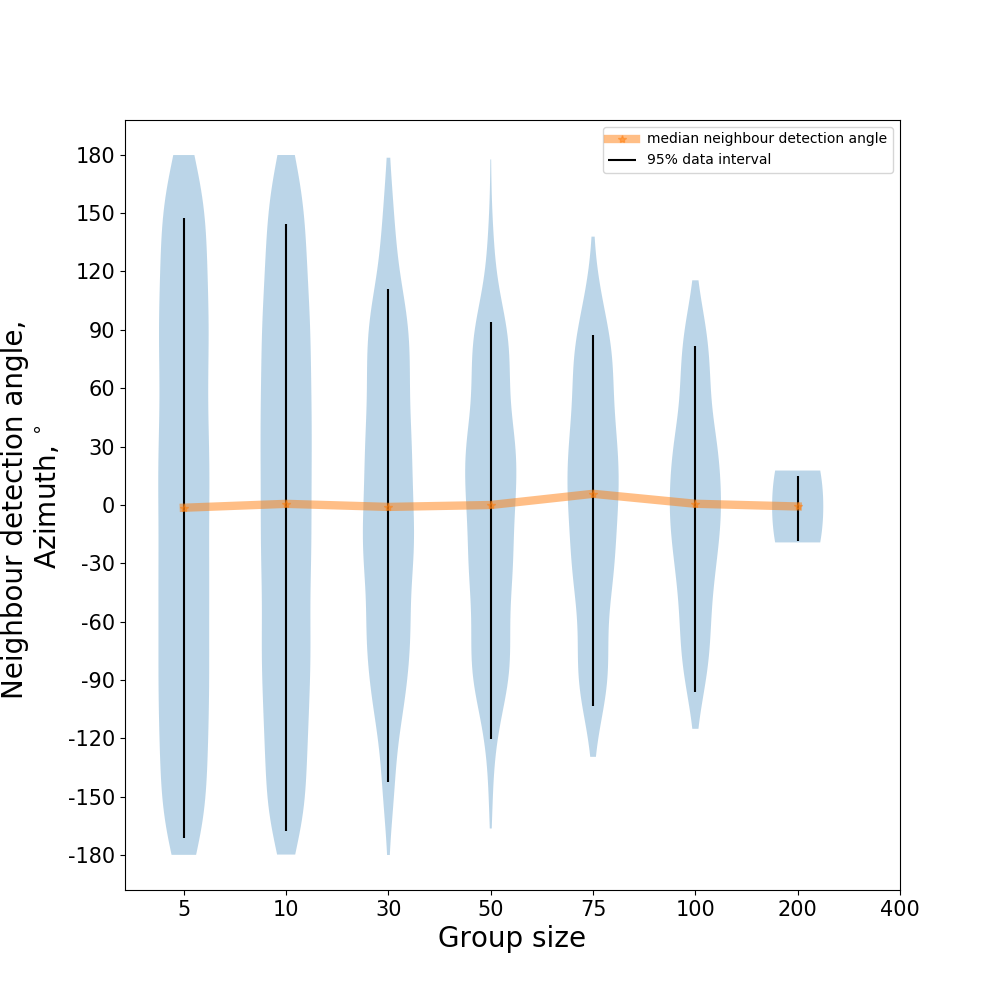

Text(0.5,0,'Group size')

In [50]:
plt.figure(figsize=(10,10))
plt.violinplot(nbrs_detected_data['neighbours_azimuth'][:-1], showextrema=False)
plt.plot(np.arange(1,9), nbrs_detected_data['median_neighbours_azimuth'], '-*', linewidth=6,
                     alpha=0.5, label='median neighbour detection angle')
plt.vlines(range(1,len(nbrs_detected_data['5%ile_neighbours_azimuth'])+1),nbrs_detected_data['5%ile_neighbours_azimuth'],
           nbrs_detected_data['95%ile_neighbours_azimuth'], label='95% data interval')
#plt.plot(np.arange(1,8), nbrs_detected_data['95%ile_neighbours_azimuth'], 'g')
#plt.plot(np.arange(1,8), nbrs_detected_data['5%ile_neighbours_azimuth'], 'g', label='95%  neighbour detection range')

plt.yticks(np.arange(-180,210,30), np.arange(-180,210,30), fontsize=15)
plt.xticks(np.arange(1,9), groupsizes, fontsize=15)
plt.legend()
plt.ylabel('Neighbour detection angle, \n  Azimuth, $^{\circ}$', fontsize=20)
plt.xlabel('Group size', fontsize=20)

### How does the received level of the echoes reflecting off neighbours change with group size?

In [51]:
nbrs_detected_data['echolevels'] = [ np.concatenate(np.array(dataframe['echo_levels'])) for groupsize, dataframe in data_by_groupsize]
nbrs_detected_data['median_echolevels'] = [ np.median(each) for each in nbrs_detected_data['echolevels']]
nbrs_detected_data['5%ile_echolevels'] = [ np.percentile(each, 2.5) for each in nbrs_detected_data['echolevels'][:-1]]
nbrs_detected_data['95%ile_echolevels'] = [ np.percentile(each, 97.5) for each in nbrs_detected_data['echolevels'][:-1]]

<IPython.core.display.Javascript object>


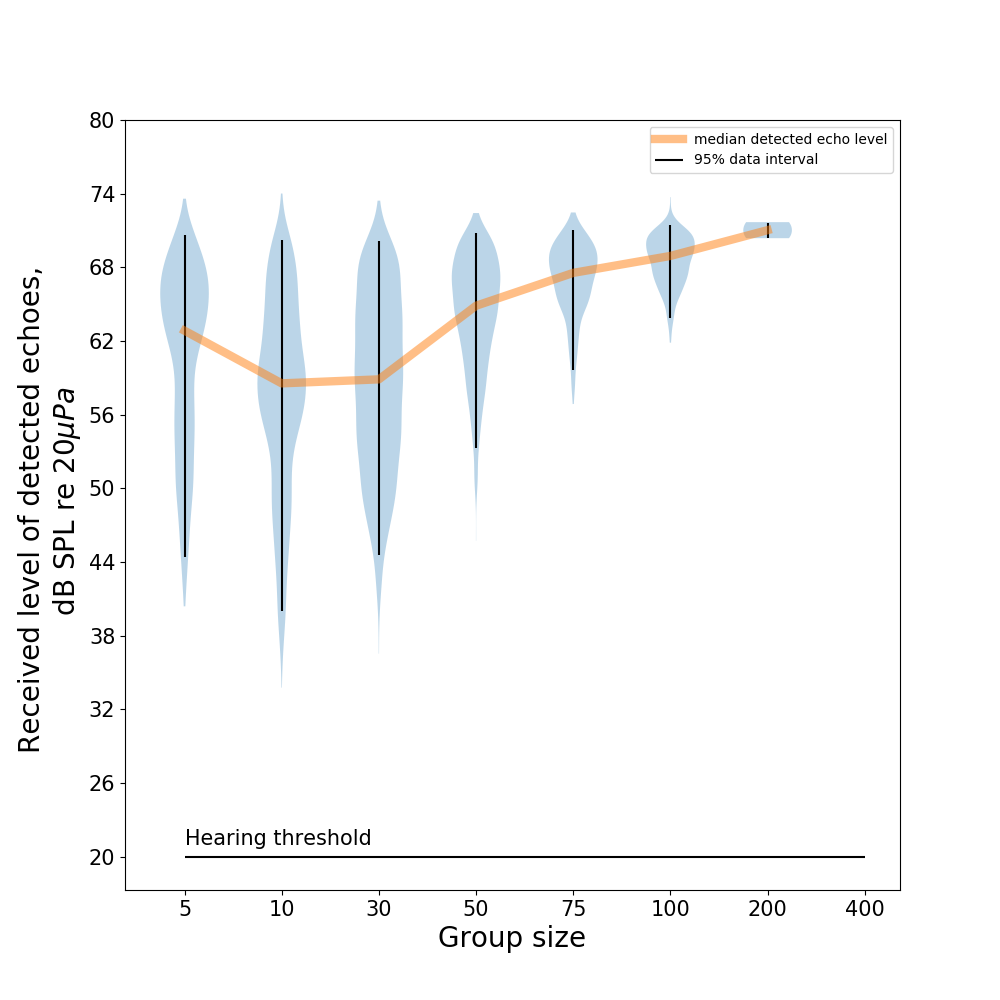

In [52]:
plt.figure(figsize=(10,10))
plt.violinplot(nbrs_detected_data['echolevels'][:-1], 
                                   showextrema=False);
plt.vlines(range(1,len(nbrs_detected_data['95%ile_echolevels'])+1),nbrs_detected_data['5%ile_echolevels'],
                                                                   nbrs_detected_data['95%ile_echolevels'],
                          label='95% data interval')

plt.plot(range(1,9), nbrs_detected_data['median_echolevels'], linewidth=6, alpha=0.5,
         label='median detected echo level')
plt.ylabel('Received level of detected echoes, \n dB SPL re 20$\mu Pa$',
                                    fontsize=20)
plt.xticks(np.arange(1,9), groupsizes, fontsize=15)
plt.hlines([20],1,8)
plt.yticks(np.arange(20,86,6),np.arange(20,86,6), fontsize=15)
plt.text(1,21,'Hearing threshold', fontsize=15)
plt.xlabel('Group size', fontsize=20)
plt.legend()